In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
dir_input = './Dataset/input_data/'
dir_target = './Dataset/target_data/'
title = 'BrandSilence'
def nonzero_coordinates(arr):
    """
    二次元配列で0.5ではない点の座標を取得する関数

    Parameters:
    - arr: 二次元配列

    Returns:
    - coordinates: (行, 列) の座標のリスト
    """
    coordinates = np.argwhere(arr != 0.5)
    return coordinates


import imageio
video_name = './Dataset/BrandSilence00001.mp4'
input_path = f"./Dataset/input_data/BrandSilence00001_150.npz"
target_path = f"./Dataset/target_data/BrandSilence00001_150.npz"
frames = np.load(input_path)['arr_0']
print('correct label: ',np.load(target_path)['arr_0'])
with imageio.get_writer(video_name, fps=30) as video:
                for i in range(150):
                    frame = np.uint8(frames[i]*255.0)  # 画像を8ビット符号なし整数に変換
                    video.append_data(frame)


correct label:  [[ -963.           779.        ]
 [ -964.79166667   776.58333333]
 [ -966.58333333   774.16666667]
 [ -968.375        771.75      ]
 [ -970.16666667   769.33333333]
 [ -971.95833333   766.91666667]
 [ -973.75         764.5       ]
 [ -975.54166667   762.08333333]
 [ -977.33333333   759.66666667]
 [ -979.125        757.25      ]
 [ -980.91666667   754.83333333]
 [ -982.70833333   752.41666667]
 [ -984.5          750.        ]
 [ -986.29166667   747.58333333]
 [ -988.08333333   745.16666667]
 [ -989.875        742.75      ]
 [ -991.66666667   740.33333333]
 [ -993.45833333   737.91666667]
 [ -995.25         735.5       ]
 [ -997.04166667   733.08333333]
 [ -998.83333333   730.66666667]
 [-1000.625        728.25      ]
 [-1002.41666667   725.83333333]
 [-1004.20833333   723.41666667]
 [-1006.           721.        ]
 [-1007.79166667   718.58333333]
 [-1009.58333333   716.16666667]
 [-1011.375        713.75      ]
 [-1013.16666667   711.33333333]
 [-1014.95833333   708.9166

In [1]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
# import cv2
import numpy as np
import glob
# import re
import rosbag
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

rosbag_files = sorted(glob.glob("/home/gen0401/Documents/research/codes/event_nlos/Dataset/rosbag/*.bag"))
rosbag_file = rosbag_files[1]
rosbag_files = [rosbag_file]
print(rosbag_file)
srcpath = glob.glob("./Dataset/src/*.txt")[0]
TOPIC_EVENTS = '/cam0/events'
SIZE_X = 640
SIZE_Y = 480
num_bins = [30, 150]
FRAMES = 150


def events_to_voxel_grid(events, num_bins, width, height):
    voxel_grid = np.zeros((num_bins, height, width), dtype=np.float32)

    # イベントデータをタイムスタンプでソート
    events = events[events[:, 0].argsort()]
    last_stamp = events[-1, 0]
    first_stamp = events[0, 0]
    deltaT = last_stamp - first_stamp

    if deltaT == 0:
        deltaT = 1.0

    for event in events:
        timestamp, x, y, polarity = event
        t_bin = int(np.clip(((timestamp - first_stamp) / deltaT) * num_bins, 0, num_bins - 1))
        x_bin = int(np.clip(x, 0, width - 1))
        y_bin = int(np.clip(y, 0, height - 1))
        assert polarity == 1 or polarity == -1

        voxel_grid[t_bin, y_bin, x_bin] += polarity
    
    return voxel_grid

def load_bag_file(path_to_bag_file):
    """Bagファイルからのイベントデータの読み込み.

    Args:
        path_to_bag_file (str): Bagファイルへのパス.
        timestamp_range (list[int]): [読み込みを始めるタイムスタンプ, 読み込みを終わるタイムスタンプ]の形式のリスト.

    Raises:
        Exceptions.FileNotExistError: Bagファイルが存在しない場合に発生.

    Returns:
        np.ndarray: イベントデータ.
    """
    
    print('Loading events...')
    
    bag = rosbag.Bag(path_to_bag_file)

    event_list = list()
    num_events = 0
    
    for topic, msg, t in bag.read_messages():
        if topic == TOPIC_EVENTS:
            new_event_list = msg.events
            event_list.extend(new_event_list)
                
            num_events += len(new_event_list)
            print('\r%d events are loaded.' % (num_events), end='')
    
    print()
    
    events = list()
    
    for event in event_list:
        x = event.x
        y = event.y
        timestamp = event.ts.nsecs
        polarity = 1 if event.polarity else -1
        #event_array = np.zeros((SIZE_X, SIZE_Y))
        #event_array[x][y] = polarity
        event_array = [timestamp, x, y, polarity]
        events.append(event_array)
    
    events = np.array(events, dtype=np.float32)

    return events

def min_max(x):
    result = np.where(x < 0, 0, np.where(x == 0, 0.5, 1))
    return result


def get_auto_keys():
    global f
    DataName = f.readline().strip()
    print("DataName = ", DataName)
    if not DataName:
        print("EOL")
        f.close()
        return None, None
    CameraVar = list(map(float, f.readline().split(",")))
    CameraPosition = CameraVar[:3]
    CameraRotation = CameraVar[3:]

    AutoKey = []
    KeyNum = int(f.readline())
    for i in range(KeyNum):
        AutoKey.append(list(map(float, f.readline().split(","))))
    
    LightNum = int(f.readline())
    for i in range(LightNum):
        f.readline()
        # do something with light positions

    # reset_keys(SMPLX_sec)
    # キーの設定
    # for key in AutoKey:
        # set_keys(SMPLX_sec, *key)
    # set camera position
    # set light position
    # set the callback function
    # generate
    # res = render_sequence_to_movie_minimal(DataName, PKG_DIR+seq_name, MovieFolderPath+DataName, on_finished_callback)
    # print('this is response from renderer: ', res)
    # if finished, remove tr
    return DataName, np.array(AutoKey)


def calculate_coordinates(data, result_coords):
    timestamps = data[:, 0].astype(float)
    coords = data[:, 1:3].astype(float)

    # 時間間隔を計算
    time_diffs = np.diff(timestamps)

    # 座標の変化量を計算
    coord_diffs = np.diff(coords, axis=0)

    # 各時間間隔ごとの速度を計算
    velocities = coord_diffs / time_diffs[:, np.newaxis]

    for i in range(int(time_diffs)):
        time_diff = i
        # 各地点での座標を計算
        if i == 0:
            new_coords = coords[0]
        else:
            new_coords = coords[0] + velocities[0] * time_diff
        result_coords = np.append(result_coords, [new_coords], axis=0)
    return result_coords

def save_voxel(file_name):
    # for num_bin in num_bins:
        name_input = file_name.replace('rosbag', 'input_data').replace('.bag', f'_{150}.npz')
        # if os.path.exists(name_input):
        #     os.remove(name_input)
        # if not os.path.exists(name_input):
        # print(f'creating file: {os.path.basename(name_input)}')
        input = load_bag_file(file_name)
        # print('bag loaded')
        input = events_to_voxel_grid(input, 150, SIZE_X, SIZE_Y)
        # print('to voxel')
        frames = np.array(input, dtype=np.int32)

        import imageio
        video_name = './BrandSilence00001.mp4'
        
        with imageio.get_writer(video_name, fps=30) as video:
                for i in range(150):
                    frame = np.uint8(frames[i]*255.0)  # 画像を8ビット符号なし整数に変換
                    video.append_data(frame)

        
        # input_norm = min_max(input)
        # print('normalized')
        # np.savez_compressed(name_input, input_norm)
        # print('saved as ',name_input)
        return 

if __name__ == "__main__":
    # shutil.rmtree('./Dataset/target_data/')
    # os.mkdir('./Dataset/target_data/')

    # for rosbag_file in rosbag_files:
        # name_input = rosbag_file.replace('rosbag', 'input_data').replace('.bag', f'_{num_bin}.npz')
        # # if os.path.exists(name_input):
        # #     os.remove(name_input)
        # # if not os.path.exists(name_input):
        # print(f'creating file: {os.path.basename(name_input)}')
        # input = load_bag_file(rosbag_file)
        # input = events_to_voxel_grid(input, num_bin, SIZE_X, SIZE_Y)
        # input = np.array(input, dtype=np.int32)
        # input_norm = min_max(input)
        # np.savez_compressed(name_input, input_norm)
    with ProcessPoolExecutor(max_workers=os.cpu_count() // 2) as executor:  # -----(2)
        tqdm(executor.map(save_voxel, rosbag_files), total=len(rosbag_files))


ModuleNotFoundError: No module named 'Cryptodome'

(150, 2)


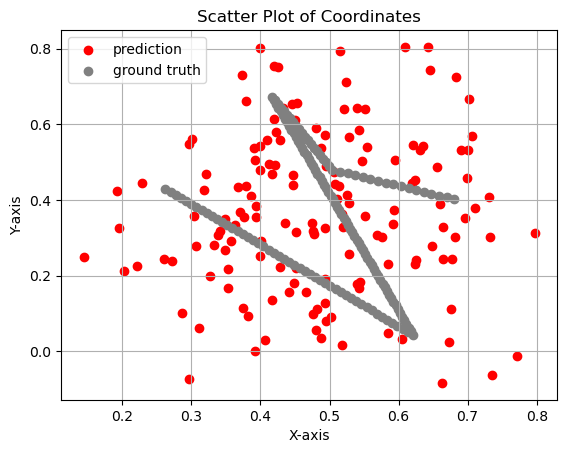

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def plot_coordinates(pred, gt):
    """
    x, y座標の集合である(150, 2)の配列をプロットする関数

    Parameters:
    coordinates (numpy.ndarray): x, y座標の集合である配列
    """
    print(gt.shape)
    # 座標の取得
    x1 = pred[:, 0]
    y1 = pred[:, 1]
    x2 = gt[:, 0]
    y2 = gt[:, 1]

    # 散布図のプロット
    plt.scatter(x1, y1, label='prediction', color='red')
    plt.scatter(x2, y2, label='ground truth', color='gray')

    # グラフの設定
    plt.title('Scatter Plot of Coordinates')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)

    # グラフの表示
    plt.show()


pred = [[ 0.1445,  0.2504],
        [ 0.3709,  0.3692],
        [ 0.1928,  0.4247],
        [ 0.2605,  0.2430],
        [ 0.3205,  0.4685],
        [ 0.4465,  0.4647],
        [ 0.1948,  0.3256],
        [ 0.3485,  0.3493],
        [ 0.5140,  0.4367],
        [ 0.3989,  0.5421],
        [ 0.3530,  0.2182],
        [ 0.3329,  0.2802],
        [ 0.3181,  0.4269],
        [ 0.2279,  0.4457],
        [ 0.4755,  0.3168],
        [ 0.3922,  0.5064],
        [ 0.3062,  0.2786],
        [ 0.3574,  0.2912],
        [ 0.4282,  0.2235],
        [ 0.4517,  0.3142],
        [ 0.2032,  0.2119],
        [ 0.4209,  0.4924],
        [ 0.3763,  0.3545],
        [ 0.4935,  0.3253],
        [ 0.2213,  0.2247],
        [ 0.4165,  0.1342],
        [ 0.2714,  0.2390],
        [ 0.5287,  0.2583],
        [ 0.3751,  0.1147],
        [ 0.6249,  0.2407],
        [ 0.4417,  0.1564],
        [ 0.3999,  0.2512],
        [ 0.3823,  0.0944],
        [ 0.5510,  0.3577],
        [ 0.5443,  0.1825],
        [ 0.5288,  0.3926],
        [ 0.5400,  0.1783],
        [ 0.6052,  0.0311],
        [ 0.6753,  0.1119],
        [ 0.2963, -0.0745],
        [ 0.4953,  0.0801],
        [ 0.3116,  0.0627],
        [ 0.4941,  0.1282],
        [ 0.7709, -0.0138],
        [ 0.5854,  0.2304],
        [ 0.5023,  0.0903],
        [ 0.4937,  0.1904],
        [ 0.6735,  0.0249],
        [ 0.6632, -0.0838],
        [ 0.4061,  0.0297],
        [ 0.4666,  0.1577],
        [ 0.4808,  0.0561],
        [ 0.5761,  0.3011],
        [ 0.4818,  0.1111],
        [ 0.7358, -0.0619],
        [ 0.5428,  0.1667],
        [ 0.7973,  0.3129],
        [ 0.6767,  0.2448],
        [ 0.6643,  0.3277],
        [ 0.5849,  0.0474],
        [ 0.3917,  0.0012],
        [ 0.6240,  0.2309],
        [ 0.5174,  0.0170],
        [ 0.4769,  0.3112],
        [ 0.3525,  0.1673],
        [ 0.4515,  0.2199],
        [ 0.3269,  0.1977],
        [ 0.5922,  0.3358],
        [ 0.5197,  0.3290],
        [ 0.4759,  0.0972],
        [ 0.6647,  0.2438],
        [ 0.3388,  0.3066],
        [ 0.3480,  0.2689],
        [ 0.4876,  0.0350],
        [ 0.2861,  0.1016],
        [ 0.7317,  0.3011],
        [ 0.6214,  0.5457],
        [ 0.4009,  0.2907],
        [ 0.4361,  0.3399],
        [ 0.6960,  0.3511],
        [ 0.6485,  0.2775],
        [ 0.5934,  0.3745],
        [ 0.6560,  0.4875],
        [ 0.4492,  0.1793],
        [ 0.3914,  0.5360],
        [ 0.5690,  0.3075],
        [ 0.6194,  0.4450],
        [ 0.6308,  0.5329],
        [ 0.5082,  0.4430],
        [ 0.6832,  0.7258],
        [ 0.5427,  0.5857],
        [ 0.3790,  0.4367],
        [ 0.4163,  0.4698],
        [ 0.2969,  0.5482],
        [ 0.3943,  0.3843],
        [ 0.5289,  0.5659],
        [ 0.3857,  0.4096],
        [ 0.5106,  0.4013],
        [ 0.5513,  0.6394],
        [ 0.3041,  0.3588],
        [ 0.4495,  0.6121],
        [ 0.4950,  0.4892],
        [ 0.4751,  0.3393],
        [ 0.3003,  0.5605],
        [ 0.5476,  0.5037],
        [ 0.3734,  0.7290],
        [ 0.3674,  0.4334],
        [ 0.4202,  0.6147],
        [ 0.5950,  0.5053],
        [ 0.4880,  0.5367],
        [ 0.6100,  0.8045],
        [ 0.5245,  0.7129],
        [ 0.4194,  0.7545],
        [ 0.3795,  0.6623],
        [ 0.4093,  0.5580],
        [ 0.4001,  0.8025],
        [ 0.4322,  0.6439],
        [ 0.4249,  0.7508],
        [ 0.4130,  0.4949],
        [ 0.5157,  0.7932],
        [ 0.4534,  0.6555],
        [ 0.4286,  0.5592],
        [ 0.5394,  0.6437],
        [ 0.4803,  0.5912],
        [ 0.3632,  0.3336],
        [ 0.6450,  0.7446],
        [ 0.3409,  0.3166],
        [ 0.5207,  0.6407],
        [ 0.5258,  0.4129],
        [ 0.4461,  0.6526],
        [ 0.4938,  0.5715],
        [ 0.4222,  0.5792],
        [ 0.6424,  0.8032],
        [ 0.7067,  0.5692],
        [ 0.4475,  0.4398],
        [ 0.3934,  0.3541],
        [ 0.5183,  0.3615],
        [ 0.7010,  0.5322],
        [ 0.5063,  0.4749],
        [ 0.6903,  0.5315],
        [ 0.5547,  0.5411],
        [ 0.6599,  0.3888],
        [ 0.6243,  0.4522],
        [ 0.3987,  0.4802],
        [ 0.7021,  0.6655],
        [ 0.6349,  0.5426],
        [ 0.6992,  0.4571],
        [ 0.7108,  0.3783],
        [ 0.6823,  0.3010],
        [ 0.7310,  0.4090]]
gt = [[0.2625, 0.4300],
        [0.2700, 0.4219],
        [0.2774, 0.4139],
        [0.2849, 0.4058],
        [0.2924, 0.3978],
        [0.2998, 0.3897],
        [0.3073, 0.3817],
        [0.3148, 0.3736],
        [0.3222, 0.3656],
        [0.3297, 0.3575],
        [0.3372, 0.3494],
        [0.3446, 0.3414],
        [0.3521, 0.3333],
        [0.3595, 0.3253],
        [0.3670, 0.3172],
        [0.3745, 0.3092],
        [0.3819, 0.3011],
        [0.3894, 0.2931],
        [0.3969, 0.2850],
        [0.4043, 0.2769],
        [0.4118, 0.2689],
        [0.4193, 0.2608],
        [0.4267, 0.2528],
        [0.4342, 0.2447],
        [0.4417, 0.2367],
        [0.4491, 0.2286],
        [0.4566, 0.2206],
        [0.4641, 0.2125],
        [0.4715, 0.2044],
        [0.4790, 0.1964],
        [0.4865, 0.1883],
        [0.4939, 0.1803],
        [0.5014, 0.1722],
        [0.5089, 0.1642],
        [0.5163, 0.1561],
        [0.5238, 0.1481],
        [0.5312, 0.1400],
        [0.5387, 0.1319],
        [0.5462, 0.1239],
        [0.5536, 0.1158],
        [0.5611, 0.1078],
        [0.5686, 0.0997],
        [0.5760, 0.0917],
        [0.5835, 0.0836],
        [0.5910, 0.0756],
        [0.5984, 0.0675],
        [0.6059, 0.0594],
        [0.6134, 0.0514],
        [0.6208, 0.0433],
        [0.6177, 0.0530],
        [0.6146, 0.0627],
        [0.6114, 0.0724],
        [0.6083, 0.0821],
        [0.6051, 0.0918],
        [0.6020, 0.1015],
        [0.5988, 0.1112],
        [0.5957, 0.1209],
        [0.5926, 0.1306],
        [0.5894, 0.1403],
        [0.5863, 0.1499],
        [0.5831, 0.1596],
        [0.5800, 0.1693],
        [0.5769, 0.1790],
        [0.5737, 0.1887],
        [0.5706, 0.1984],
        [0.5674, 0.2081],
        [0.5643, 0.2178],
        [0.5612, 0.2275],
        [0.5580, 0.2372],
        [0.5549, 0.2469],
        [0.5517, 0.2566],
        [0.5486, 0.2663],
        [0.5454, 0.2759],
        [0.5423, 0.2856],
        [0.5392, 0.2953],
        [0.5360, 0.3050],
        [0.5329, 0.3147],
        [0.5297, 0.3244],
        [0.5266, 0.3341],
        [0.5235, 0.3438],
        [0.5203, 0.3535],
        [0.5172, 0.3632],
        [0.5140, 0.3729],
        [0.5109, 0.3826],
        [0.5078, 0.3923],
        [0.5046, 0.4019],
        [0.5015, 0.4116],
        [0.4983, 0.4213],
        [0.4952, 0.4310],
        [0.4921, 0.4407],
        [0.4889, 0.4504],
        [0.4858, 0.4601],
        [0.4826, 0.4698],
        [0.4795, 0.4795],
        [0.4763, 0.4892],
        [0.4732, 0.4989],
        [0.4701, 0.5086],
        [0.4669, 0.5183],
        [0.4638, 0.5279],
        [0.4606, 0.5376],
        [0.4575, 0.5473],
        [0.4544, 0.5570],
        [0.4512, 0.5667],
        [0.4481, 0.5764],
        [0.4449, 0.5861],
        [0.4418, 0.5958],
        [0.4387, 0.6055],
        [0.4355, 0.6152],
        [0.4324, 0.6249],
        [0.4292, 0.6346],
        [0.4261, 0.6443],
        [0.4229, 0.6539],
        [0.4198, 0.6636],
        [0.4167, 0.6733],
        [0.4210, 0.6637],
        [0.4254, 0.6540],
        [0.4298, 0.6443],
        [0.4342, 0.6347],
        [0.4385, 0.6250],
        [0.4429, 0.6153],
        [0.4473, 0.6057],
        [0.4517, 0.5960],
        [0.4560, 0.5863],
        [0.4604, 0.5767],
        [0.4648, 0.5670],
        [0.4692, 0.5573],
        [0.4735, 0.5477],
        [0.4779, 0.5380],
        [0.4823, 0.5283],
        [0.4867, 0.5187],
        [0.4910, 0.5090],
        [0.4954, 0.4993],
        [0.4998, 0.4897],
        [0.5042, 0.4800],
        [0.5152, 0.4751],
        [0.5262, 0.4702],
        [0.5373, 0.4653],
        [0.5483, 0.4604],
        [0.5593, 0.4555],
        [0.5703, 0.4506],
        [0.5814, 0.4457],
        [0.5924, 0.4408],
        [0.6034, 0.4359],
        [0.6145, 0.4310],
        [0.6255, 0.4261],
        [0.6365, 0.4212],
        [0.6475, 0.4163],
        [0.6586, 0.4114],
        [0.6696, 0.4065],
        [0.6806, 0.4016]]

pred_np = np.array(pred)
gt_np = np.array(gt)
plot_coordinates(pred_np, gt_np)